In [27]:
# Import file handling packages
import subprocess
import os
import sys

# Import data science packages
import pandas as pd
import sklearn
import umap

import arcadia_pycolor as apc

# Import custom utility scripts
sys.path.append('../utils')
import databases
import plotting

# Set reference to top of Git repository
GIT_HOME = subprocess.run(['git', 'rev-parse', '--show-toplevel'], stdout=subprocess.PIPE).stdout.decode("utf-8").strip('\n')
# Set reference to global output directory
GLOBAL_OUTPUT_DIRECTORY = GIT_HOME + '/output/'

# Set directory for current analysis run
output_folder = GLOBAL_OUTPUT_DIRECTORY + '20230331_test/'

---
## 1. Ingest FoldSeek results data

Use `databases.ingest_results()`, which does the following:
- Takes the raw FoldSeek output file `all_by_all_tmscore.tsv`
- Clean it of excess columns and reformat to long-format; save that file with `_cleaned.tsv` suffix
- Pivot long-format matrix to a similarity matrix; save a copy with `_simm_matrix.tsv` suffix
- Return a pandas `DataFrame` with the similarity matrix loaded

In [28]:
# Specify path to foldseek results file
foldseek_results_filepath = output_folder + 'all_by_all_tmscore.tsv'

# This does a bunch of things, as described above. Use help() to find out more
pivoted_df = databases.ingest_results(foldseek_results_filepath)

File /Users/dennis/Code/gene-family-cartography/output/20230331_test/all_by_all_tmscore_cleaned.tsv already exists. Replace with overwrite = True.
File already exists at /Users/dennis/Code/gene-family-cartography/output/20230331_test/all_by_all_tmscore_simm_matrix.tsv. Replace using overwrite = True.


In [29]:
# Inspect df to make sure it looks right
display(pivoted_df.head(3))

target                         AF-A0A016UFC9-F1-model_v4.pdb   
query                                                          
AF-A0A016UFC9-F1-model_v4.pdb                         1.0000  \
AF-A0A023EHK0-F1-model_v4.pdb                         0.3623   
AF-A0A023FSS9-F1-model_v4.pdb                         0.4517   

target                         AF-A0A023EHK0-F1-model_v4.pdb   
query                                                          
AF-A0A016UFC9-F1-model_v4.pdb                            0.0  \
AF-A0A023EHK0-F1-model_v4.pdb                            1.0   
AF-A0A023FSS9-F1-model_v4.pdb                            0.0   

target                         AF-A0A023FSS9-F1-model_v4.pdb   
query                                                          
AF-A0A016UFC9-F1-model_v4.pdb                         0.4409  \
AF-A0A023EHK0-F1-model_v4.pdb                         0.5159   
AF-A0A023FSS9-F1-model_v4.pdb                         1.0000   

target                         AF-A0A023G0S7-F1-model_v4.pdb   
query                                                          
AF-A0A016UFC9-F1-model_v4.pdb                         0.3803  \
AF-A0A023EHK0-F1-model_v4.pdb                         0.4573   
AF-A0A023FSS9-F1-model_v4.pdb                         0.6783   

target                         AF-A0A023G9T4-F1-model_v4.pdb   
query                                                          
AF-A0A016UFC9-F1-model_v4.pdb                         0.4297  \
AF-A0A023EHK0-F1-model_v4.pdb                         0.5584   
AF-A0A023FSS9-F1-model_v4.pdb                         0.6290   

target                         AF-A0A023GC25-F1-model_v4.pdb   
query                                                          
AF-A0A016UFC9-F1-model_v4.pdb                         0.3659  \
AF-A0A023EHK0-F1-model_v4.pdb                         0.0000   
AF-A0A023FSS9-F1-model_v4.pdb                         0.7571   

target                         AF-A0A034WTW9-F1-model_v4.pdb   
query                                                          
AF-A0A016UFC9-F1-model_v4.pdb                         0.4398  \
AF-A0A023EHK0-F1-model_v4.pdb                         0.4558   
AF-A0A023FSS9-F1-model_v4.pdb                         0.7154   

target                         AF-A0A044RAX3-F1-model_v4.pdb   
query                                                          
AF-A0A016UFC9-F1-model_v4.pdb                            0.0  \
AF-A0A023EHK0-F1-model_v4.pdb                            0.0   
AF-A0A023FSS9-F1-model_v4.pdb                            0.0   

target                         AF-A0A044RHJ8-F1-model_v4.pdb   
query                                                          
AF-A0A016UFC9-F1-model_v4.pdb                         0.4161  \
AF-A0A023EHK0-F1-model_v4.pdb                         0.5404   
AF-A0A023FSS9-F1-model_v4.pdb                         0.4109   

target                         AF-A0A044V409-F1-model_v4.pdb  ...   
query                                                         ...   
AF-A0A016UFC9-F1-model_v4.pdb                            0.0  ...  \
AF-A0A023EHK0-F1-model_v4.pdb                            0.0  ...   
AF-A0A023FSS9-F1-model_v4.pdb                            0.0  ...   

target                         AF-W5LWQ8-F1-model_v4.pdb   
query                                                      
AF-A0A016UFC9-F1-model_v4.pdb                     0.2191  \
AF-A0A023EHK0-F1-model_v4.pdb                     0.3982   
AF-A0A023FSS9-F1-model_v4.pdb                     0.5063   

target                         AF-W5MHL8-F1-model_v4.pdb   
query                                                      
AF-A0A016UFC9-F1-model_v4.pdb                     0.2222  \
AF-A0A023EHK0-F1-model_v4.pdb                     0.3666   
AF-A0A023FSS9-F1-model_v4.pdb                     0.4645   

target                         AF-W5MKH3-F1-model_v4.pdb   
query                                                      
AF-A0A016UFC9-F1-model_v4.pdb              

---
## 2. Load and format feature dataframes

Load in dataframes for the features you want to be able to overlay in scatter plots.  
You should make sure that each dataframe has a column that corresponds to the values in the `index` column of your `pivoted_df`.  
You should also specify a `shared_column` that is the name of that dataframe column in all dataframes.  

For this example, we use the AlphaFold .pdb filename as our `shared_column`.

### 2.1 Load FoldSeek Structural Cluster information

In [30]:
strucluster_df = pd.read_csv(output_folder + 'foldseek_struclusters.tsv', sep = '\t')
display(strucluster_df.head(2))

shared_column = 'filename'

filename  uniprot_id StruCluster
0  AF-A0A1L8FE91-F1-model_v4.pdb  A0A1L8FE91         SC0
1  AF-A0A044RHJ8-F1-model_v4.pdb  A0A044RHJ8         SC0

### 2.2 Load UniProtKB mapping results
You can get a lot of information using UniProt ID mapping.  
Here, we have to create a new `'filename'` column in the dataframe to make sure we can aggregate things properly.

In [31]:
pattern = 'AF-*-F1-model_v4.pdb'

uniprot_df = pd.read_csv(output_folder + 'TSP_UniprotKB_mapping_expanded.tsv', sep = '\t')
uniprot_df[shared_column] = uniprot_df['Entry'].apply(lambda x: databases.entry_to_filename(x, pattern))
display(uniprot_df.head(2))

From       Entry    Reviewed        Entry Name   
0  A0A0A0V684  A0A0A0V684  unreviewed  A0A0A0V684_SCYTH  \
1  A0A4D9ERY4  A0A4D9ERY4  unreviewed  A0A4D9ERY4_9SAUR   

                                Protein names      Gene Names   
0  IGFBP N-terminal domain-containing protein             NaN  \
1                           BCL-6 corepressor  DR999_PMT07106   

                                            Organism  Length   
0  Scytodes thoracica (Spitting spider) (Aranea t...      92  \
1      Platysternon megacephalum (big-headed turtle)     475   

                                   Taxonomic lineage   
0  Scytodes (genus), Scytodidae (family), Scytodo...  \
1  Platysternon (genus), Platysternidae (family),...   

                                            Sequence Fragment  Annotation   
0  MKSALVIAFALLVVACSLIHVTEAFGCVPGECDPXKCPAVDSCKCG...      NaN         1.0  \
1  MLLWLSWAGGCCLLLLLPGGAAERAAGCPERCDRARCPPVPADCAG...      NaN         1.0   

                                             Caution  Organism (ID)   
0                                                NaN        1112478  \
1  CAUTION: The sequence shown here is derived fr...          55544   

                        filename  
0  AF-A0A0A0V684-F1-model_v4.pdb  
1  AF-A0A4D9ERY4-F1-model_v4.pdb

---
## 3. Aggregate features

Aggregate features using `databases.aggregate_features()`, passing the following arguments:
- `pivoted_df`: the pivoted DataFrame
- `feature_dfs`: a list of DataFrames containing the features you want to aggregate
- `shared_column`: the shared column between all dataframes and the `pivoted_df` that will be used to aggregate them  

This returns a DataFrame with matching order to the `index` of the `pivoted_df` with all relevant information aggregated.  
In cases where the value is `NaN`, this is replaced with the string `None` for compatibility with downstream processes.

In [32]:
feature_dfs = [strucluster_df, uniprot_df] #[, , fragment_df, functional_region_df]

agg_features_df = databases.aggregate_features(pivoted_df, feature_dfs, shared_column)
display(agg_features_df)

filename  uniprot_id StruCluster        From   
0     AF-A0A016UFC9-F1-model_v4.pdb  A0A016UFC9         SC7  A0A016UFC9  \
1     AF-A0A023EHK0-F1-model_v4.pdb  A0A023EHK0         SC4  A0A023EHK0   
2     AF-A0A023FSS9-F1-model_v4.pdb  A0A023FSS9         SC9  A0A023FSS9   
3     AF-A0A023G0S7-F1-model_v4.pdb  A0A023G0S7         SC9  A0A023G0S7   
4     AF-A0A023G9T4-F1-model_v4.pdb  A0A023G9T4         SC9  A0A023G9T4   
...                             ...         ...         ...         ...   
1729      AF-W5UKZ8-F1-model_v4.pdb      W5UKZ8         SC4      W5UKZ8   
1730      AF-W6MEX4-F1-model_v4.pdb      W6MEX4         SC6      W6MEX4   
1731      AF-W7TY09-F1-model_v4.pdb      W7TY09         SC0      W7TY09   
1732      AF-X1WGX6-F1-model_v4.pdb      X1WGX6         SC9      X1WGX6   
1733      AF-X1XIC8-F1-model_v4.pdb      X1XIC8         SC0        None   

           Entry    Reviewed        Entry Name   
0     A0A016UFC9  unreviewed  A0A016UFC9_9BILA  \
1     A0A023EHK0  unreviewed  A0A023EHK0_AEDAL   
2     A0A023FSS9  unreviewed  A0A023FSS9_AMBCJ   
3     A0A023G0S7  unreviewed  A0A023G0S7_AMBTT   
4     A0A023G9T4  unreviewed  A0A023G9T4_AMBTT   
...          ...         ...               ...   
1729      W5UKZ8  unreviewed      W5UKZ8_ICTPU   
1730      W6MEX4  unreviewed      W6MEX4_PAGBR   
1731      W7TY09  unreviewed      W7TY09_9STRA   
1732      X1WGX6  unreviewed      X1WGX6_DANRE   
1733        None        None              None   

                                          Protein names   
0                  Cysteine-rich motor neuron 1 protein  \
1         Putative cysteine-rich motor neuron 1 protein   
2                             Putative secreted protein   
3                             Putative secreted protein   
4                             Putative secreted protein   
...                                                 ...   
1729     Insulin-like growth factor-binding protein 2-A   
1730  Kazal-type-serine-protease-inhibitor-like-2 pr...   
1731  Kazal-type serine protease inhibitor domain pr...   
1732                                   Si:ch73-330k17.3   
1733                                               None   

                                    Gene Names   
0     Acey_s0042.g664 Acey-crm-1 Y032_0042g664  \
1                                         None   
2                                         None   
3                                         None   
4                                         None   
...                                        ...   
1729                                   igfbp2a   
1730                                      None   
1731                             Naga_100032g7   
1732                          si:ch73-330k17.3   
1733                                      None   

                                               Organism Length   
0                                Ancylostoma ceylanicum  897.0  \
1     Aedes albopictus (Asian tiger mosquito) (Stego...  190.0   
2     Amblyomma cajennense (Cayenne tick) (Acarus ca...  108.0   
3                   Amblyomma triste (Neotropical tick)  126.0   
4                   Amblyomma triste (Neotropical tick)  155.0   
...                                                 ...    ...   
1729  Ictalurus punctatus (Channel catfish) (Silurus...  301.0   
1730  Pagurus bernhardus (Common hermit crab) (Eupag...  120.0   
1731                           Nannochloropsis gaditana  570.0   
1732        Danio rerio (Zebrafish) (Brachydanio rerio)  221.0   
1733                                               None   None   

                                      Taxonomic lineage   
0     Ancylostoma (genus), Ancylostomatinae (subfami...  \
1     Stegomyia (subgenus), Aedes (genus), Aedini (t...   
2     Amblyomma (genus), Amblyomminae (subfamily), I...   
3     Amblyomma (genus), Amblyomminae (subfamily), I...   
4     Amblyomma (genus), Amblyomminae (subfamily), I...   
...                                                 ...   
1729  Ict

### 3.1 Export feature files for downstream analysis

In [69]:
agg_features_df.to_csv(output_folder + 'actin_all_features.tsv', index = None, sep = '\t')

In [70]:
proteins_by_strucluster = agg_features_df[['From', 'Entry', 'StruCluster', 'filename']]
proteins_by_strucluster.rename({'From': 'Genbank_id', 'Entry': 'uniprot_id'})
proteins_by_strucluster.to_csv(output_folder + 'actin_proteins_by_FoldSeek_strucluster.tsv', index = None, sep = '\t')

---
## 4. Calculate embeddings

In [71]:
random_state = 20230301

PCA_features = plotting.calculate_PCA(pivoted_df, agg_features_df)
TSNE_features = plotting.calculate_TSNE(pivoted_df, agg_features_df, 
                                        random_state = random_state, learning_rate = 'auto', init = 'pca')
UMAP_features = plotting.calculate_UMAP(pivoted_df, agg_features_df, random_state = random_state)

Initializing PCA function.
Calculating PCA...
Done!
Initializing TSNE function.
Calculating TSNE...
Done!
Initializing UMAP function.
Calculating UMAP...
Done!


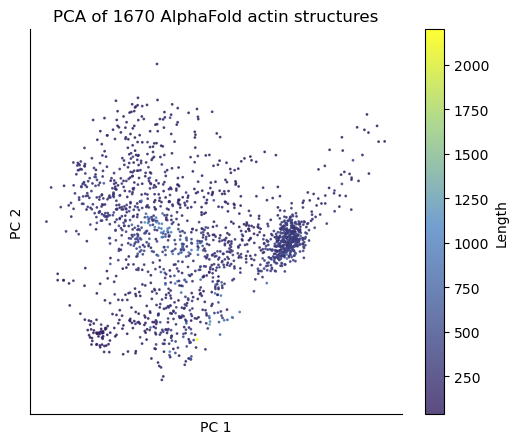

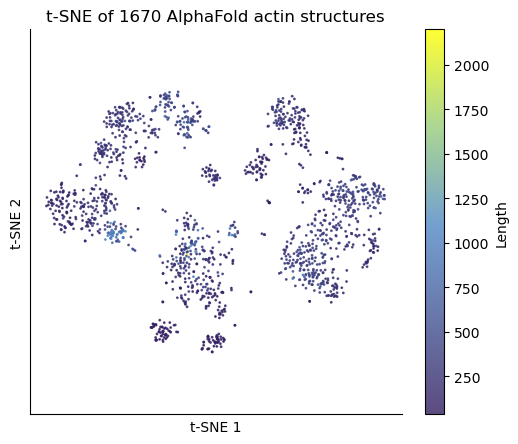

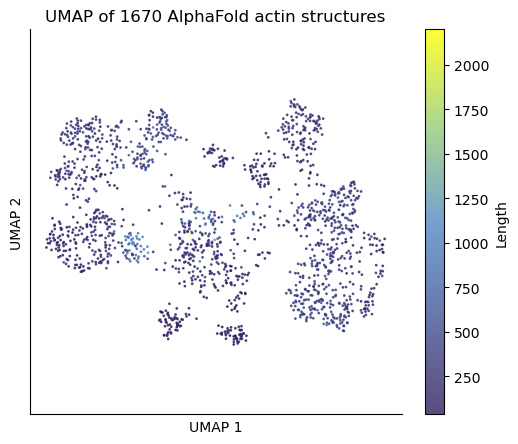

In [72]:
PCA_features = PCA_features[PCA_features['From'] != 'None']
TSNE_features = TSNE_features[TSNE_features['From'] != 'None']
UMAP_features = UMAP_features[UMAP_features['From'] != 'None']

figures_folder = output_folder + 'figures/'

pca_plot_loc = figures_folder + 'TSP-insulin_filtered_length_PCA.png'
plotting.plot_static_continuous(features_df = PCA_features, feature = 'Length', cmap = 'arcadia:viridis',
           title = 'PCA of {} AlphaFold actin structures'.format(str(len(PCA_features))), 
           xlabel = 'PC 1', ylabel = 'PC 2', save_to = pca_plot_loc,
           s = 1, alpha = 0.8)
            
tsne_plot_loc = figures_folder + 'TSP-insulin_filtered_length_tSNE.png'
plotting.plot_static_continuous(features_df = TSNE_features, feature = 'Length', cmap = 'arcadia:viridis', 
           title = 't-SNE of {} AlphaFold actin structures'.format(str(len(PCA_features))), 
           xlabel = 't-SNE 1', ylabel = 't-SNE 2', save_to = tsne_plot_loc,
           s = 1, alpha = 0.8)

umap_plot_loc = figures_folder + 'TSP-insulin_filtered_length_UMAP.png'
plotting.plot_static_continuous(features_df = UMAP_features, feature = 'Length', cmap = 'arcadia:viridis',
           title = 'UMAP of {} AlphaFold actin structures'.format(str(len(PCA_features))), 
           xlabel = 'UMAP 1', ylabel = 'UMAP 2', save_to = umap_plot_loc,
           s = 1, alpha = 0.8)

## 6. Plot a categorical feature on a static plot

In [73]:
import arcadia_pycolor as apc
colors = list(apc.arcadia_Accent_all.values())
pca_color_mapper = plotting.make_color_mapper(PCA_features, 'StruCluster', colors, permute = [0.75])

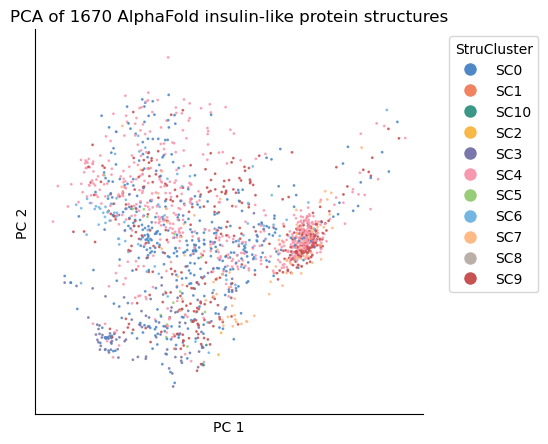

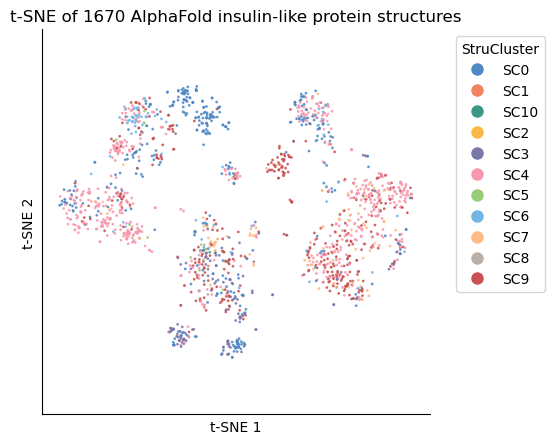

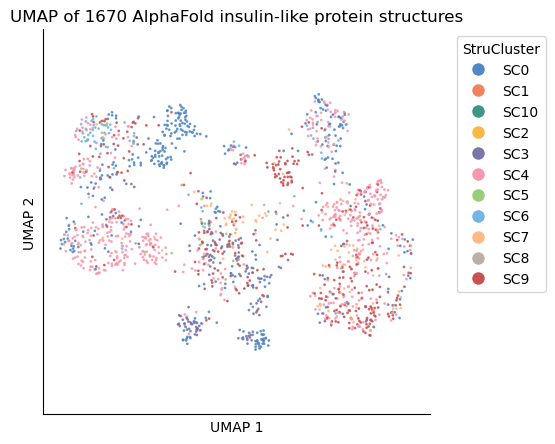

In [74]:
cluster_pca_plot_loc = figures_folder + 'TSP-insulin_filtered_SC_PCA.png'
plotting.plot_static_categorical(features_df = PCA_features, feature = 'StruCluster', color_mapper = pca_color_mapper,
               title = 'PCA of {} AlphaFold insulin-like protein structures'.format(len(PCA_features)),
               xlabel = 'PC 1', ylabel = 'PC 2', figsize = (5, 5), save_to = cluster_pca_plot_loc, 
               s = 1, alpha = 0.8)

cluster_tsne_plot_loc = figures_folder + 'TSP-insulin_filtered_SC_tSNE.png'
plotting.plot_static_categorical(features_df = TSNE_features, feature = 'StruCluster', color_mapper = pca_color_mapper,
               title = 't-SNE of {} AlphaFold insulin-like protein structures'.format(len(PCA_features)),
               xlabel = 't-SNE 1', ylabel = 't-SNE 2', figsize = (5, 5), save_to = cluster_tsne_plot_loc, 
               s = 1, alpha = 0.8)

cluster_umap_plot_loc = figures_folder + 'TSP-insulin_filtered_SC_UMAP.png'
plotting.plot_static_categorical(features_df = UMAP_features, feature = 'StruCluster', color_mapper = pca_color_mapper,
               title = 'UMAP of {} AlphaFold insulin-like protein structures'.format(len(PCA_features)),
               xlabel = 'UMAP 1', ylabel = 'UMAP 2', figsize = (5, 5), save_to = cluster_umap_plot_loc, 
               s = 1, alpha = 0.8)

## 7. Manually specifying a `color_mapper` dictionary

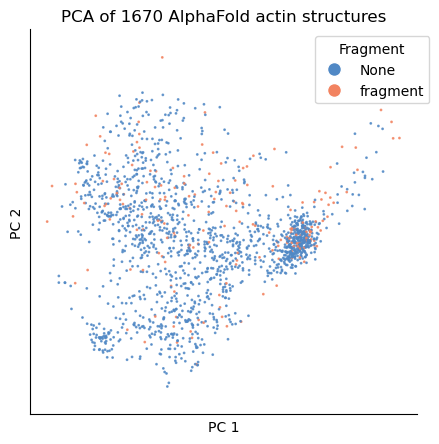

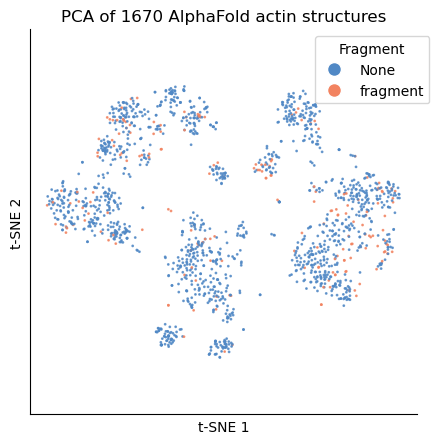

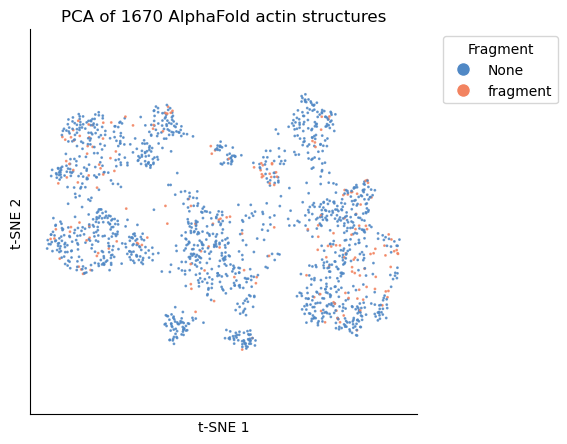

In [76]:
colors = list(apc.arcadia_Accent_all.values())

fragment_color_mapper = {
    'None': apc.arcadia_Accent_all['arcadia:aegean'],
    'fragment': apc.arcadia_Accent_all['arcadia:amber']
}

fragment_pca_plot_loc = figures_folder + 'actin_filtered_fragment_PCA.png'
plotting.plot_static_categorical(features_df = PCA_features, feature = 'Fragment', color_mapper = fragment_color_mapper,
               title = 'PCA of {} AlphaFold actin structures'.format(len(PCA_features)),
               xlabel = 'PC 1', ylabel = 'PC 2', figsize = (5, 5), save_to = fragment_pca_plot_loc, 
               s = 1, alpha = 0.8, return_colors = True, hide_None = False)

fragment_tsne_plot_loc = figures_folder + 'actin_filtered_fragment_tSNE.png'
plotting.plot_static_categorical(features_df = TSNE_features, feature = 'Fragment', color_mapper = fragment_color_mapper,
               title = 'PCA of {} AlphaFold actin structures'.format(len(PCA_features)),
               xlabel = 't-SNE 1', ylabel = 't-SNE 2', figsize = (5, 5), save_to = fragment_tsne_plot_loc, 
               s = 1, alpha = 0.8, hide_None = False)

fragment_umap_plot_loc = figures_folder + 'actin_filtered_fragment_UMAP.png'
plotting.plot_static_categorical(features_df = UMAP_features, feature = 'Fragment', color_mapper = fragment_color_mapper,
               title = 'PCA of {} AlphaFold actin structures'.format(len(PCA_features)),
               xlabel = 't-SNE 1', ylabel = 't-SNE 2', figsize = (5, 5), save_to = fragment_umap_plot_loc, 
               s = 1, alpha = 0.8, hide_None = False)

## 8. Sequential PCA → t-SNE or UMAP

In [77]:
n_components = 30

PCA_30_features = plotting.calculate_PCA(pivoted_df, agg_features_df, n_components = n_components)
PCA_TSNE_features = plotting.calculate_TSNE(PCA_30_features, agg_features_df, 
                                        random_state = random_state, learning_rate = 'auto', init = 'pca')
PCA_UMAP_features = plotting.calculate_UMAP(PCA_30_features, agg_features_df, random_state = random_state)

Initializing PCA function.
Calculating PCA...
Done!
Initializing TSNE function.
Calculating TSNE...
Done!
Initializing UMAP function.
Calculating UMAP...
Done!


## 9. Inherit coloring from another plot using `return_colors = True`

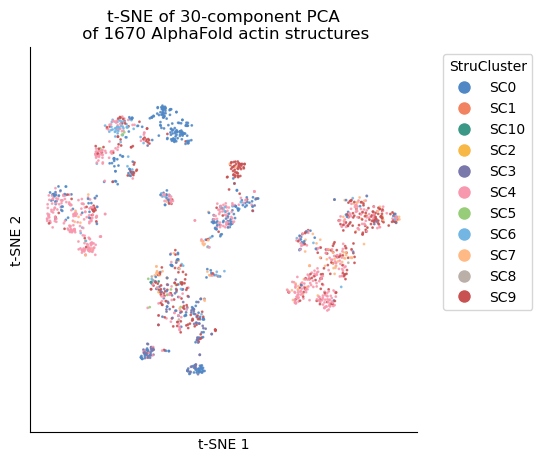

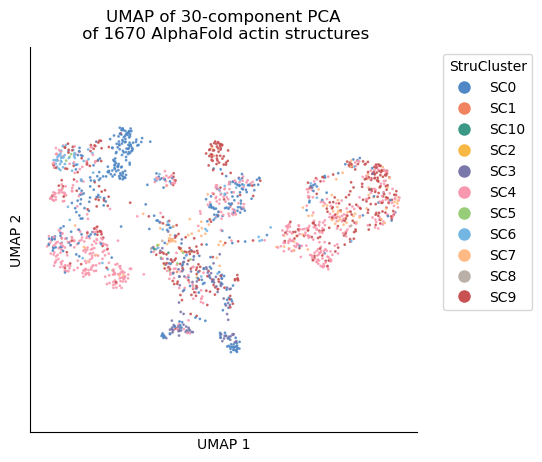

In [78]:
cluster_pca_tsne_plot_loc = figures_folder + 'actin_filtered_SC_PCA-UMAP.png'
pca_color_mapper_2 = plotting.plot_static_categorical(features_df = PCA_TSNE_features, feature = 'StruCluster', color_list = colors, permute = [0.75],
               title = 't-SNE of {}-component PCA\n of {} AlphaFold actin structures'.format(n_components, len(PCA_features)),
               xlabel = 't-SNE 1', ylabel = 't-SNE 2', figsize = (5, 5), save_to = cluster_pca_tsne_plot_loc, 
               s = 1, alpha = 0.8, return_colors = True)

cluster_pca_umap_plot_loc = figures_folder + 'actin_filtered_SC_PCA-tSNE.png'
plotting.plot_static_categorical(features_df = PCA_UMAP_features , feature = 'StruCluster', color_mapper = pca_color_mapper_2,
               title = 'UMAP of {}-component PCA\n of {} AlphaFold actin structures'.format(n_components, len(PCA_features)),
               xlabel = 'UMAP 1', ylabel = 'UMAP 2', figsize = (5, 5), save_to = cluster_pca_umap_plot_loc, 
               s = 1, alpha = 0.8)

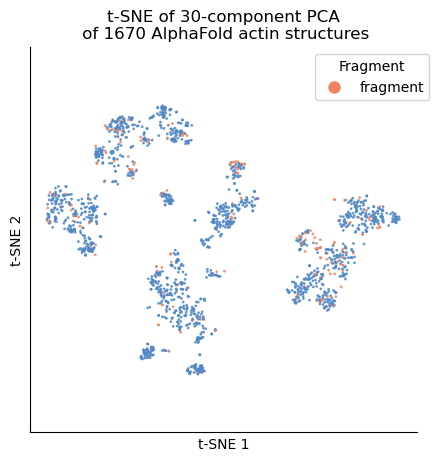

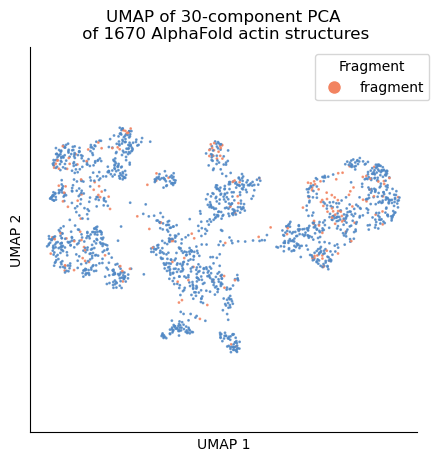

In [80]:
fragment_pca_tsne_plot_loc = figures_folder + 'actin_filtered_fragment_PCA-UMAP.png'
plotting.plot_static_categorical(features_df = PCA_TSNE_features, feature = 'Fragment', color_mapper = fragment_color_mapper,
               title = 't-SNE of {}-component PCA\n of {} AlphaFold actin structures'.format(n_components, len(PCA_features)),
               xlabel = 't-SNE 1', ylabel = 't-SNE 2', figsize = (5, 5), save_to = fragment_pca_tsne_plot_loc, 
               s = 1, alpha = 0.8)

fragment_pca_umap_plot_loc = figures_folder + 'actin_filtered_fragment_PCA-tSNE.png'
plotting.plot_static_categorical(features_df = PCA_UMAP_features , feature = 'Fragment', color_mapper = fragment_color_mapper,
               title = 'UMAP of {}-component PCA\n of {} AlphaFold actin structures'.format(n_components, len(PCA_features)),
               xlabel = 'UMAP 1', ylabel = 'UMAP 2', figsize = (5, 5), save_to = fragment_pca_umap_plot_loc, 
               s = 1, alpha = 0.8)

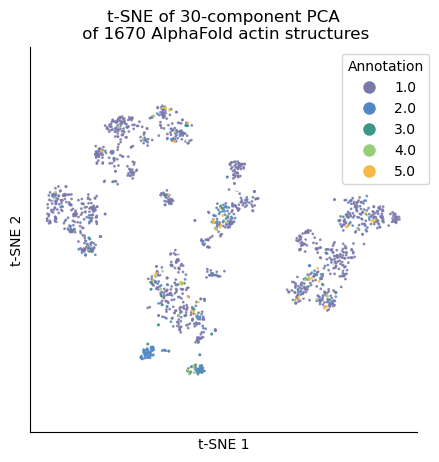

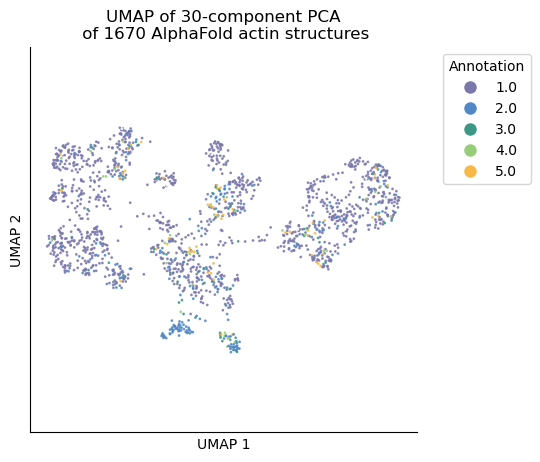

In [86]:
annotation_color_mapper = {
    1.0: apc.arcadia_Accent_all['arcadia:aster'],
    2.0: apc.arcadia_Accent_all['arcadia:aegean'],
    3.0: apc.arcadia_Accent_all['arcadia:seaweed'],
    4.0: apc.arcadia_Accent_all['arcadia:lime'],
    5.0: apc.arcadia_Accent_all['arcadia:canary'],
    'None': '#FFFFFF'
}

fragment_pca_tsne_plot_loc = figures_folder + 'actin_filtered_fragment_PCA-UMAP.png'
plotting.plot_static_categorical(features_df = PCA_TSNE_features, feature = 'Annotation', color_mapper = annotation_color_mapper,
               title = 't-SNE of {}-component PCA\n of {} AlphaFold actin structures'.format(n_components, len(PCA_features)),
               xlabel = 't-SNE 1', ylabel = 't-SNE 2', figsize = (5, 5), save_to = fragment_pca_tsne_plot_loc, 
               s = 1, alpha = 0.8)

fragment_pca_umap_plot_loc = figures_folder + 'actin_filtered_fragment_PCA-tSNE.png'
plotting.plot_static_categorical(features_df = PCA_UMAP_features , feature = 'Annotation', color_mapper = annotation_color_mapper,
               title = 'UMAP of {}-component PCA\n of {} AlphaFold actin structures'.format(n_components, len(PCA_features)),
               xlabel = 'UMAP 1', ylabel = 'UMAP 2', figsize = (5, 5), save_to = fragment_pca_umap_plot_loc, 
               s = 1, alpha = 0.8)

In [ ]:
keyactins_df = pd.read_csv(output_folder + 'specific_actins.txt', sep = '\t', names = ['RefSeq', 'uniprot_id', 'Species'])
keyactins_df['filename'] = 'AF-' + keyactins_df['uniprot_id'] + '-F1-model_v4.pdb'

keyactins_df['index'] = list(ordering[ordering['filename'].isin(keyactins_df['filename'])].index)
display(keyactins_df)

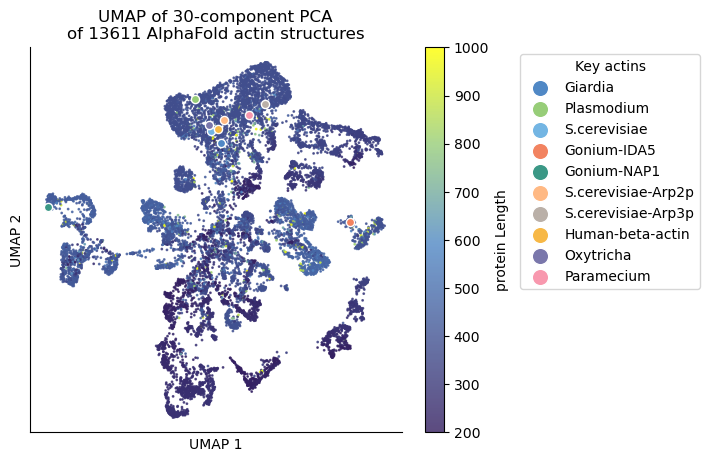

In [35]:
plt.figure(figsize = (6, 5))
plt.scatter(umap_step2[:, 0], umap_step2[:, 1], s = 1, alpha = 0.8, c = ordering['Length'], cmap = 'arcadia:viridis')
plt.colorbar(label = 'protein Length')

color_labels_actin = sorted(keyactins_df['Species'].unique())
apc_colors = list(apc.arcadia_Accent_full.values())[0:len(color_labels_actin)]

color_mapper_actin = dict(zip(color_labels_actin, apc_colors))

for index in keyactins_df['index'].values:
    labeltxt = keyactins_df[keyactins_df['index'] == index]['Species'].values[0]
    
    plt.scatter(umap_step2[index, 0], umap_step2[index, 1], s = 35, c = color_mapper_actin[labeltxt], edgecolors = 'white', label = labeltxt)
    #ax = plt.gca()
    
    #ax.annotate(labeltxt, (umap_step2[index, 0] + 0.1, umap_step2[index, 1] + 0.1) , fontsize = 8)
plt.legend(bbox_to_anchor = (1.3, 1), markerscale = 2, title = 'Key actins')

plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft = False)
plt.title('UMAP of {}-component PCA\nof {} AlphaFold actin structures'.format(str(pca_components), str(len(strucluster_ordering))))
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

ax = plt.gca()
ax.set_aspect('equal', adjustable='datalim')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(output_folder + 'figures/' + 'actin_filtered_length-keyactin_PCA-UMAP.png', bbox_inches='tight')
plt.show()

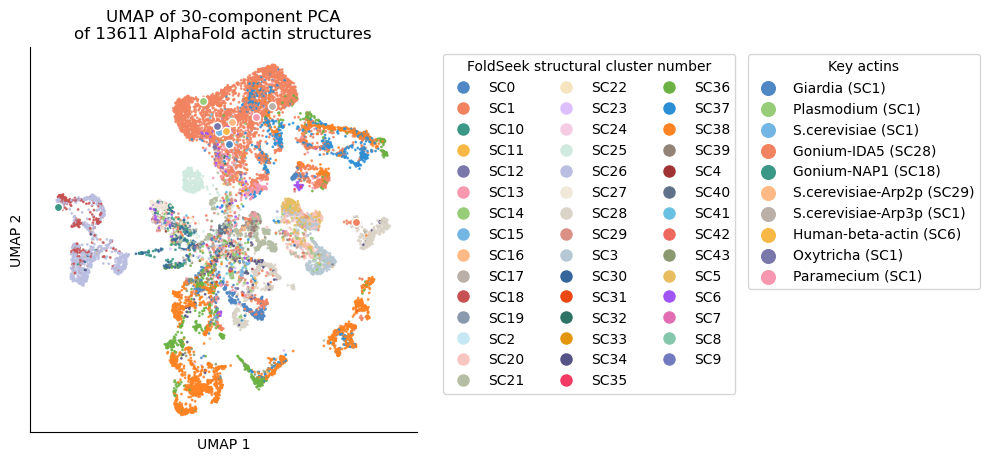

In [36]:
plt.figure(figsize = (5, 5))
plt.scatter(umap_step2[:, 0], umap_step2[:, 1], s = 1, alpha = 0.8, c = strucluster_ordering['StruCluster'].map(color_mapper))

first_legend = plt.legend(handles = legend_elements, bbox_to_anchor = (1.05, 1), ncol = 3, title = 'FoldSeek structural cluster number')
ax = plt.gca().add_artist(first_legend)

for index in keyactins_df['index'].values:
    labeltxt = keyactins_df[keyactins_df['index'] == index]['Species'].values[0]
    labeltxt2 = labeltxt + ' ({})'.format(strucluster_ordering.iloc[int(index)]['StruCluster'])
    
    plt.scatter(umap_step2[index, 0], umap_step2[index, 1], s = 35, c = color_mapper_actin[labeltxt], edgecolors = 'white', label = labeltxt2)
plt.legend(bbox_to_anchor = (2.47, 1), markerscale = 2, title = 'Key actins')
    
plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft = False)
plt.title('UMAP of {}-component PCA\nof {} AlphaFold actin structures'.format(str(pca_components), str(len(strucluster_ordering))))
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

ax = plt.gca()
ax.set_aspect('equal', adjustable='datalim')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(output_folder + 'figures/' + 'actin_filtered_SC-keyactin_PCA-UMAP.png', bbox_inches='tight')
plt.show()

In [62]:
functional_region_df = pd.read_csv(GLOBAL_OUTPUT_DIRECTORY + 'all_outputs_summarized-2.tsv', sep = '\t')

uniprotkb_idmapping_result = pd.read_csv(GLOBAL_OUTPUT_DIRECTORY + 'actin_UniprotKB_mapping_expanded.tsv', sep = '\t')
uniprotkb_idmapping_pairs = uniprotkb_idmapping_result[['From', 'Entry']]

functional_region_mapper = functional_region_df.merge(uniprotkb_idmapping_pairs, left_on = 'protein', right_on = 'From')

functional_ordering = ordering.merge(functional_region_mapper, on = 'Entry').drop_duplicates('Entry')
functional_ordering.fillna(-0.1, inplace = True)
display(functional_ordering)

/tmp/ipykernel_44064/3341360862.py:3: DtypeWarning:

Columns (18,20,30,33) have mixed types. Specify dtype option on import or set low_memory=False.



filename       Entry  Length     protein  \
0      AF-A0A010RHW1-F1-model_v4.pdb  A0A010RHW1     448  EXF77404.1   
1      AF-A0A010SEV7-F1-model_v4.pdb  A0A010SEV7     439  EXF83313.1   
2      AF-A0A015ICG5-F1-model_v4.pdb  A0A015ICG5     318  EXX51530.1   
3      AF-A0A015J9J4-F1-model_v4.pdb  A0A015J9J4     328  EXX51529.1   
4      AF-A0A015LM00-F1-model_v4.pdb  A0A015LM00     415  EXX73701.1   
...                              ...         ...     ...         ...   
13656      AF-X6PEL9-F1-model_v4.pdb      X6PEL9     405  ETO36925.1   
13657      AF-X8J267-F1-model_v4.pdb      X8J267     389  EUC56050.1   
13658      AF-X8J2N8-F1-model_v4.pdb      X8J2N8     375  EUC56270.1   
13659      AF-X8JP43-F1-model_v4.pdb      X8JP43     432  EUC64946.1   
13660      AF-X8JQC3-F1-model_v4.pdb      X8JQC3     438  EUC65376.1   

       lon_feature_count  lon_num_matching  lon_fraction_matching  \
0                     39              -0.1              -0.100000   
1                     39              11.0               0.282051   
2                     39              -0.1              -0.100000   
3                     39              -0.1              -0.100000   
4                     39              -0.1              -0.100000   
...                  ...               ...                    ...   
13656                 39              -0.1              -0.100000   
13657                 39              16.0               0.410256   
13658                 39              37.0               0.948718   
13659                 39              13.0               0.333333   
13660                 39              -0.1              -0.100000   

       lat_feature_count  lat_num_matching  lat_fraction_matching  ...  \
0                      7              -0.1              -0.100000  ...   
1                      7               0.0               0.000000  ...   
2                      7               3.0               0.428571  ...   
3                      7              -0.1              -0.100000  ...   
4                      7              -0.1              -0.100000  ...   
...                  ...               ...                    ...  ...   
13656                  7              -0.1              -0.100000  ...   
13657                  7               5.0               0.714286  ...   
13658                  7               7.0               1.000000  ...   
13659                  7               1.0               0.142857  ...   
13660                  7               1.0               0.142857  ...   

       domain_number_exp  domain_number_reg  domain_number_clu  \
0                    1.0                  1                  0   
1                    1.0                  1                  0   
2                    1.0                  1                  0   
3                    1.0                  1                  0   
4                    1.0                  1                  0   
...                  ...                ...                ...   
13656                1.0                  1                  0   
13657                1.0                  1                  0   
13658                1.0                  1                  0   
13659                1.0                  1                  0   
13660                1.0                  1                  0   

       domain_number_ov  domain_number_env  domain_number_dom  \
0                     0                  1                  1   
1                     0                  1                  1   
2                     0                  1                  1   
3                     0                  1                  1   
4                     0                  1                  1   
...                 ...                ...                ...   
13656                 0                  1                  1   
13657                 0                  1                  1   
13658                 0                  1                  1   
13

In [120]:
uniprotkb_playground = uniprotkb_idmapping_result.copy(deep = True)

#entry.partition('(*)')[1].strip('()'): entry.split(' ') for entry in 
taxlineage_unpacker = lambda x: {entry.split(' (')[0]: entry.split(' (')[1].strip(')') for entry in x.split(', ')}

def taxlineage_aggregator(input_dict):
    output_dict = {}
    for value, category in input_dict.items():
        if category not in output_dict:
            output_dict[category] = [value]
        else:
            output_dict[category] = output_dict[category] + [value]
    output_dict = {key: value.pop() if len(value) == 1 else value for key, value in output_dict.items()}
    return output_dict

uniprotkb_playground['taxlineage_dict'] = uniprotkb_playground['Taxonomic lineage'].apply(taxlineage_unpacker)
uniprotkb_playground['taxlineage_summary'] = uniprotkb_playground['taxlineage_dict'].apply(taxlineage_aggregator)

In [125]:
taxlineage_cols = uniprotkb_playground['taxlineage_summary'].apply(pd.Series)
display(taxlineage_cols.columns)

uniprotkb_playground2 = pd.concat([uniprotkb_playground, taxlineage_cols], axis=1)
display(uniprotkb_playground2)

Index(['genus', 'subfamily', 'family', 'infraorder', 'suborder', 'order',
       'superorder', 'no rank', 'class', 'superclass', 'subphylum', 'phylum',
       'kingdom', 'superkingdom', 'parvorder', 'superfamily', 'infraclass',
       'subcohort', 'cohort', 'subclass', 'tribe', 'subgenus', 'species',
       'subtribe', 'subkingdom', 'varietas', 'subspecies', 'in: Viridiplantae',
       'in: Chlorellales', 'Poeae type', 'Aveneae type', 'in: Mollusca',
       'in: Saccharomycetales', 'in: Debaryomycetaceae', 'in: Leotiomycetes',
       'forma'],
      dtype='object')

From       Entry    Reviewed        Entry Name  \
0      KAG5195459.1  A0A836CS00  unreviewed  A0A836CS00_SHEEP   
1        TEA41296.1  A0A484H1H1  unreviewed  A0A484H1H1_SOUCH   
2      KAF6081813.1  A0A833YM98  unreviewed  A0A833YM98_9CHIR   
3      KAF6447643.1  A0A7J8FIQ0  unreviewed  A0A7J8FIQ0_ROUAE   
4        AAS55927.1      Q6QAQ1    reviewed          ACTB_PIG   
...             ...         ...         ...               ...   
20360  KAF8796026.1  A0A8T0FZC2  unreviewed  A0A8T0FZC2_ARGBR   
20361    AAZ99445.1      Q2LL21  unreviewed      Q2LL21_9CHLO   
20362    CAO85359.1      B2G1H0  unreviewed      B2G1H0_ANOAR   
20363    OCT64880.1  A0A974H563  unreviewed  A0A974H563_XENLA   
20364    CZR66348.1  A0A1L7XMV0  unreviewed  A0A1L7XMV0_9HELO   

                                           Protein names           Gene Names  \
0                                   Actin, cytoplasmic 1         JEQ12_012748   
1                                             Beta-actin  DBR06_SOUSAS9810109   
2                                           ACTB protein         HJG60_008822   
3                                      Actin beta like 2         HJG63_012046   
4      Actin, cytoplasmic 1 (EC 3.6.4.-) (Beta-actin)...                 ACTB   
...                                                  ...                  ...   
20360               Actin-related protein 6 like protein         HNY73_000456   
20361                                       Type I actin                  NaN   
20362                         ENSANGG00000011698 protein   ENSANGG00000011698   
20363                            Uncharacterized protein    XELAEV_18041117mg   
20364                      Related to actin-like protein            PAC_16249   

                                                Organism  Length  \
0                                     Ovis aries (Sheep)     452   
1      Sousa chinensis (Indo-pacific humpbacked dolph...     410   
2           Phyllostomus discolor (pale spear-nosed bat)     383   
3      Rousettus aegyptiacus (Egyptian rousette) (Egy...     384   
4                                       Sus scrofa (Pig)     375   
...                                                  ...     ...   
20360  Argiope bruennichi (Wasp spider) (Aranea bruen...     318   
20361                    uncultured Trebouxia photobiont      66   
20362                    Anopheles arabiensis (Mosquito)     190   
20363               Xenopus laevis (African clawed frog)     417   
20364                            Phialocephala subalpina     432   

      Gene Names (synonym)                                  Taxonomic lineage  \
0                      NaN  Ovis (genus), Caprinae (subfamily), Bovidae (f...   
1                      NaN  Sousa (genus), Delphinidae (family), Odontocet...   
2                      NaN  Phyllostomus (genus), Phyllostominae (subfamil...   
3                      NaN  Rousettus (genus), Pteropodinae (subfamily), P...   
4                      NaN  Sus (genus), Suidae (family), Suina (suborder)...   
...                    ...                                                ...   
20360                  NaN  Argiope (genus), Araneidae (family), Araneoide...   
20361                  NaN  environmental samples (no rank), Trebouxia (ge...   
20362                  NaN  gambiae species complex (no rank), Pyretophoru...   
20363                  NaN  Xenopus (subgenus), Xenopus (genus), Xenopodin...   
20364                  NaN  Phialocephala fortinii species complex (no ran...   

       ... subspecies  in: Viridiplantae in: Chlorellales Poeae type  \
0      ...        NaN                NaN              NaN        NaN   
1      ...        NaN                NaN              NaN        NaN   
2      ...        NaN                NaN              NaN        NaN   
3      ...        NaN                NaN              NaN        NaN   
4      ...        NaN                NaN              NaN        NaN   
...    ...        ...                ..

In [129]:
taxlineage_ordering = ordering.merge(uniprotkb_playground2, on = 'Entry').drop_duplicates('Entry').fillna('None')
display(taxlineage_ordering)

filename       Entry  Length_x        From  \
0      AF-A0A010RHW1-F1-model_v4.pdb  A0A010RHW1       448  EXF77404.1   
1      AF-A0A010SEV7-F1-model_v4.pdb  A0A010SEV7       439  EXF83313.1   
2      AF-A0A015ICG5-F1-model_v4.pdb  A0A015ICG5       318  EXX51530.1   
3      AF-A0A015J9J4-F1-model_v4.pdb  A0A015J9J4       328  EXX51529.1   
4      AF-A0A015LM00-F1-model_v4.pdb  A0A015LM00       415  EXX73701.1   
...                              ...         ...       ...         ...   
13656      AF-X6PEL9-F1-model_v4.pdb      X6PEL9       405  ETO36925.1   
13657      AF-X8J267-F1-model_v4.pdb      X8J267       389  EUC56050.1   
13658      AF-X8J2N8-F1-model_v4.pdb      X8J2N8       375  EUC56270.1   
13659      AF-X8JP43-F1-model_v4.pdb      X8JP43       432  EUC64946.1   
13660      AF-X8JQC3-F1-model_v4.pdb      X8JQC3       438  EUC65376.1   

         Reviewed        Entry Name                      Protein names  \
0      unreviewed  A0A010RHW1_9PEZI                              Actin   
1      unreviewed  A0A010SEV7_9PEZI               Actin-like protein 3   
2      unreviewed  A0A015ICG5_RHIIW                              Actin   
3      unreviewed  A0A015J9J4_RHIIW                              Actin   
4      unreviewed  A0A015LM00_RHIIW                              Arp6p   
...           ...               ...                                ...   
13656  unreviewed      X6PEL9_RETFI                              Actin   
13657  unreviewed      X8J267_9AGAM         Actin-related protein Arp2   
13658  unreviewed      X8J2N8_9AGAM                            Actin-2   
13659  unreviewed      X8JP43_9AGAM  Arp3-actin-like protein, putative   
13660  unreviewed      X8JQC3_9AGAM        Actin-related protein Arp4p   

         Gene Names                                           Organism  \
0      CFIO01_05854                       Colletotrichum fioriniae PJ7   
1      CFIO01_04563                       Colletotrichum fioriniae PJ7   
2       RirG_260920  Rhizophagus irregularis (strain DAOM 197198w) ...   
3       RirG_260920  Rhizophagus irregularis (strain DAOM 197198w) ...   
4       RirG_058050  Rhizophagus irregularis (strain DAOM 197198w) ...   
...             ...                                                ...   
13656     RFI_00137                                Reticulomyxa filosa   
13657   RSOL_156780                     Rhizoctonia solani AG-3 Rhs1AP   
13658   RSOL_168500                     Rhizoctonia solani AG-3 Rhs1AP   
13659   RSOL_494710                     Rhizoctonia solani AG-3 Rhs1AP   
13660   RSOL_445420                     Rhizoctonia solani AG-3 Rhs1AP   

       Length_y  ... subspecies in: Viridiplantae in: Chlorellales  \
0           448  ...       None              None             None   
1           439  ...       None              None             None   
2           318  ...       None              None             None   
3           328  ...       None              None             None   
4           415  ...       None              None             None   
...         ...  ...        ...               ...              ...   
13656       405  ...       None              None             None   
13657       389  ...       None              None             None   
13658       375  ...       None              None             None   
13659       432  ...       None              None             None   
13660       438  ...       None              None             None   

       Poeae type Aveneae type in: Mollusca  in: Saccharomycetales  \
0            None         None         None                   None   
1            None         None         None                   None   
2            None         None         None                   None   
3            None         None         None                   None   
4            None         None         None                   None   
...           ...          ...          ...                    ...   
13656        None         None

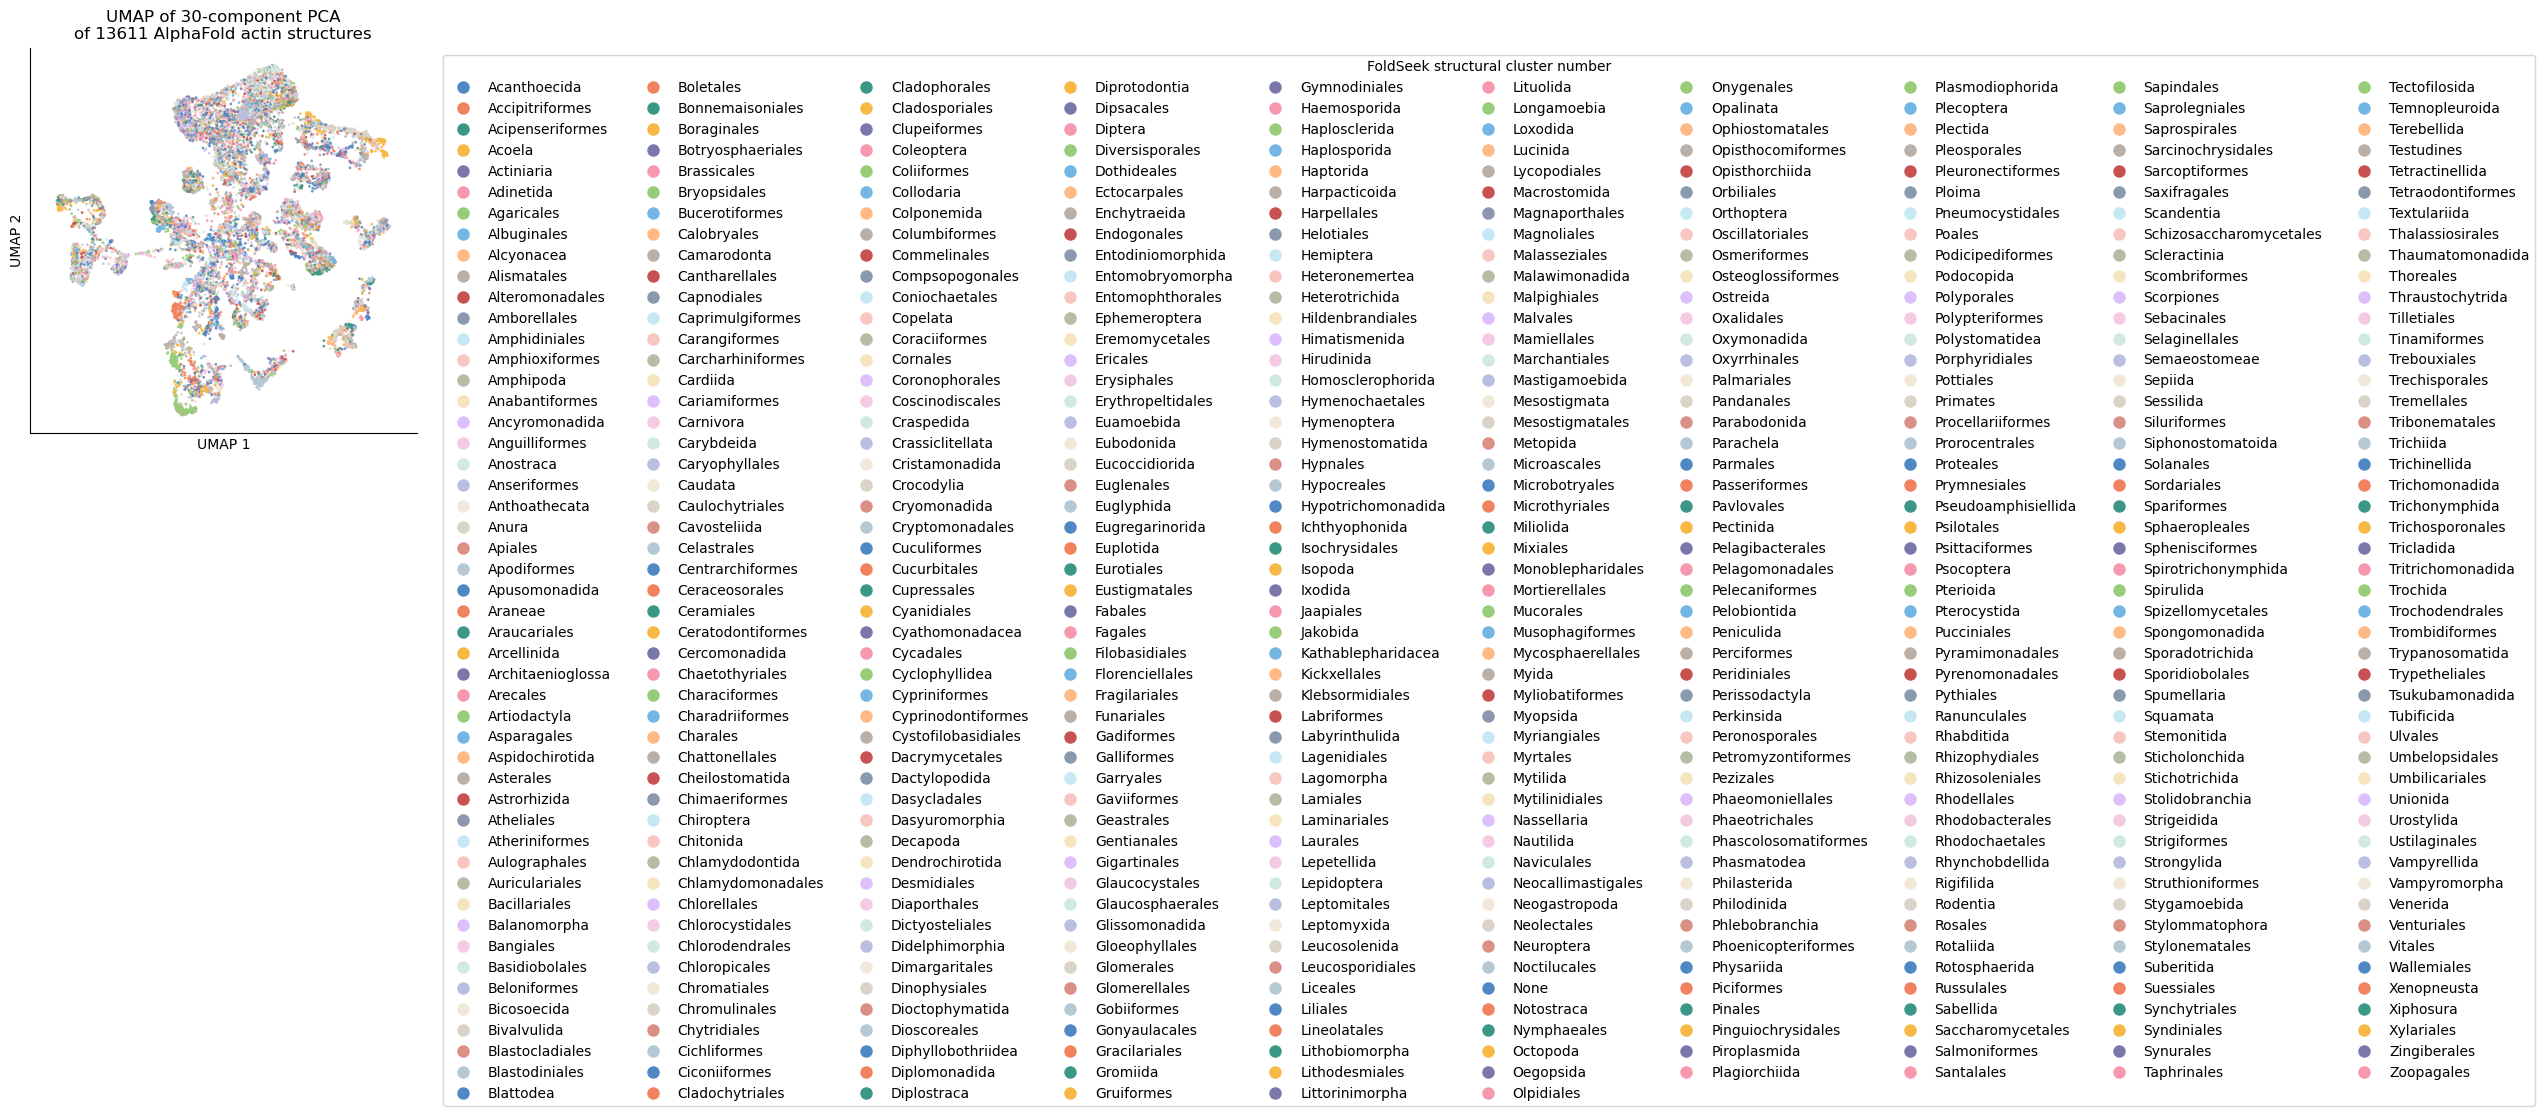

In [135]:
color_labels3 = sorted(taxlineage_ordering['order'].unique())

apc_colors3 = list(apc.arcadia_Accent_all.values())*30

color_mapper3 = dict(zip(color_labels3, apc_colors3))


plt.figure(figsize = (5, 5))
plt.scatter(umap_step2[:, 0], umap_step2[:, 1], s = 1, alpha = 0.8, c = taxlineage_ordering['order'].map(color_mapper3))

legend_elements_3 = [mpl.lines.Line2D([0], [0], marker='o', color='w', label=label,
                          markerfacecolor=apc_color, markersize=10) for label, apc_color in color_mapper3.items()]

plt.legend(handles = legend_elements_3, bbox_to_anchor = (1.05, 1), ncol = 10, title = 'FoldSeek structural cluster number')

plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft = False)
plt.title('UMAP of {}-component PCA\nof {} AlphaFold actin structures'.format(str(pca_components), str(len(taxlineage_ordering))))
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

ax = plt.gca()
ax.set_aspect('equal', adjustable='datalim')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(output_folder + 'figures/' + 'actin_filtered_taxlineage:order_PCA-UMAP.png', bbox_inches='tight')
plt.show()

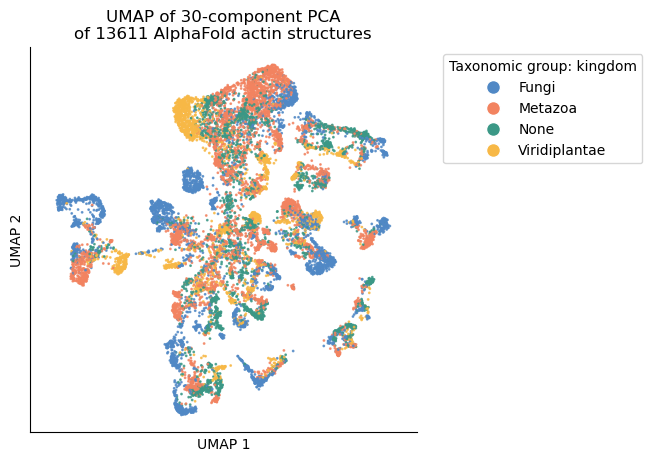

In [153]:
color_labels3 = sorted(taxlineage_ordering['kingdom'].unique())

apc_colors3 = list(apc.arcadia_Accent_all.values())*30

color_mapper3 = dict(zip(color_labels3, apc_colors3))


plt.figure(figsize = (5, 5))
plt.scatter(umap_step2[:, 0], umap_step2[:, 1], s = 1, alpha = 0.8, c = taxlineage_ordering['kingdom'].map(color_mapper3))

legend_elements_3 = [mpl.lines.Line2D([0], [0], marker='o', color='w', label=label,
                          markerfacecolor=apc_color, markersize=10) for label, apc_color in color_mapper3.items()]

plt.legend(handles = legend_elements_3, bbox_to_anchor = (1.05, 1), ncol = 1, title = 'Taxonomic group: kingdom')

plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft = False)
plt.title('UMAP of {}-component PCA\nof {} AlphaFold actin structures'.format(str(pca_components), str(len(taxlineage_ordering))))
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

ax = plt.gca()
ax.set_aspect('equal', adjustable='datalim')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(output_folder + 'figures/' + 'actin_filtered_taxlineage:kingdom_PCA-UMAP.png', bbox_inches='tight')
plt.show()

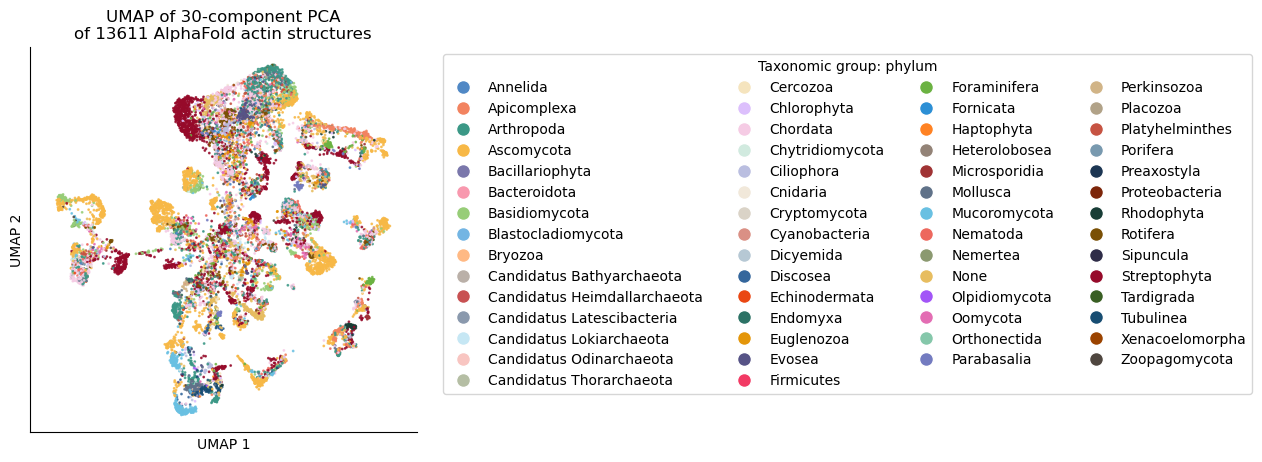

In [154]:
color_labels3 = sorted(taxlineage_ordering['phylum'].unique())

apc_colors3 = list(apc.arcadia_Accent_all.values())
apc_colors3 = apc_colors3 + [mpl.colors.to_hex(apc.adjust_lightness(color, 0.75)) for color in apc.arcadia_Accent_all.values()] + [mpl.colors.to_hex(apc.adjust_lightness(color, 0.4)) for color in apc.arcadia_Accent_all.values()]

color_mapper3 = dict(zip(color_labels3, apc_colors3))


plt.figure(figsize = (5, 5))
plt.scatter(umap_step2[:, 0], umap_step2[:, 1], s = 1, alpha = 0.8, c = taxlineage_ordering['phylum'].map(color_mapper3))

legend_elements_3 = [mpl.lines.Line2D([0], [0], marker='o', color='w', label=label,
                          markerfacecolor=apc_color, markersize=10) for label, apc_color in color_mapper3.items()]

plt.legend(handles = legend_elements_3, bbox_to_anchor = (1.05, 1), ncol = 4, title = 'Taxonomic group: phylum')

plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft = False)
plt.title('UMAP of {}-component PCA\nof {} AlphaFold actin structures'.format(str(pca_components), str(len(taxlineage_ordering))))
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

ax = plt.gca()
ax.set_aspect('equal', adjustable='datalim')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(output_folder + 'figures/' + 'actin_filtered_taxlineage:phylum_PCA-UMAP.png', bbox_inches='tight')
plt.show()

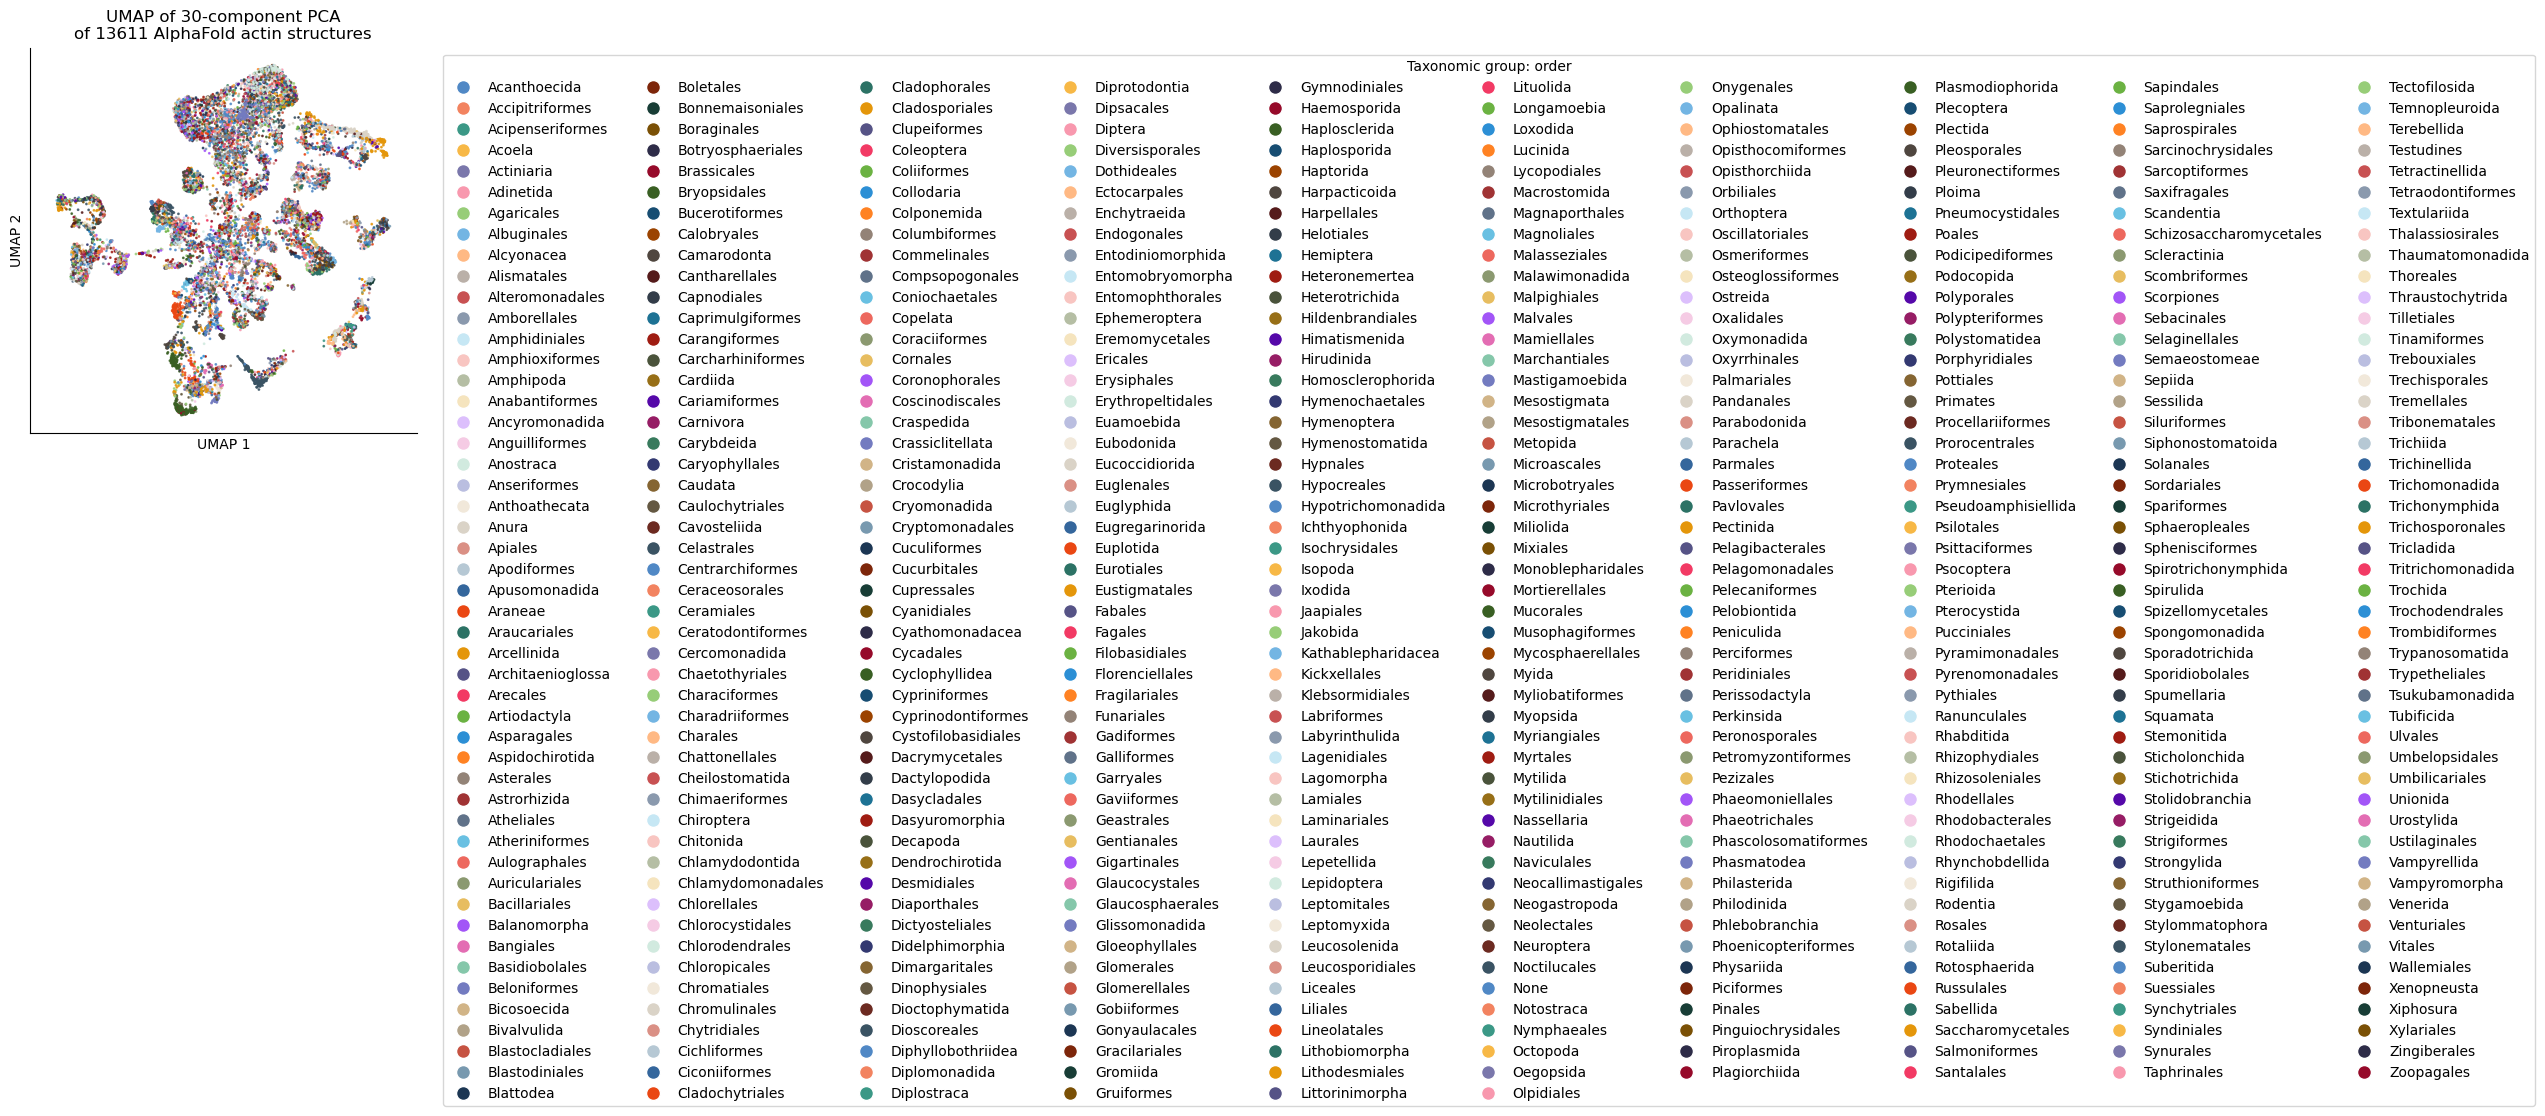

In [164]:
taxgroup = 'order'

color_labels3 = sorted(taxlineage_ordering[taxgroup].unique())

apc_colors3 = list(apc.arcadia_Accent_all.values())
apc_colors3 = apc_colors3 + [mpl.colors.to_hex(apc.adjust_lightness(color, 0.75)) for color in apc.arcadia_Accent_all.values()] + [mpl.colors.to_hex(apc.adjust_lightness(color, 0.4)) for color in apc.arcadia_Accent_all.values()]
apc_colors3 = apc_colors3 * 20

color_mapper3 = dict(zip(color_labels3, apc_colors3))


plt.figure(figsize = (5, 5))
plt.scatter(umap_step2[:, 0], umap_step2[:, 1], s = 1, alpha = 0.8, c = taxlineage_ordering[taxgroup].map(color_mapper3))

legend_elements_3 = [mpl.lines.Line2D([0], [0], marker='o', color='w', label=label,
                          markerfacecolor=apc_color, markersize=10) for label, apc_color in color_mapper3.items()]

plt.legend(handles = legend_elements_3, bbox_to_anchor = (1.05, 1), ncol = 10, title = 'Taxonomic group: {}'.format(taxgroup))

plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft = False)
plt.title('UMAP of {}-component PCA\nof {} AlphaFold actin structures'.format(str(pca_components), str(len(taxlineage_ordering))))
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

ax = plt.gca()
ax.set_aspect('equal', adjustable='datalim')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(output_folder + 'figures/' + 'actin_filtered_taxlineage:{}_PCA-UMAP.png'.format(taxgroup), bbox_inches='tight')
plt.show()